# Import Libraries

In [21]:
# Common imports
import os
import numpy as np

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
# TensorFlow imports
# may differs from version to versions

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image

## Set Some Parameters

In [23]:
# Dataset information

# Test dataset is set explicitly, because the amount of data is very small
train_image_folder = os.path.join('datasets', 'face_dataset_train_images')
test_image_folder = os.path.join('datasets', 'face_dataset_test_images')
img_height, img_width = 250, 250  # size of images
num_classes = 3  # human - not human - epi

# Training settings
validation_ratio = 0.15  # 15% for the validation
batch_size = 16

AUTOTUNE = tf.data.AUTOTUNE

## Create Dataset

### Read datasets from folders

In [24]:
# Train and validation sets
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

val_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True)

Found 684 files belonging to 3 classes.
Using 582 files for training.
Found 684 files belonging to 3 classes.
Using 102 files for validation.


In [25]:
# Test set
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_image_folder,
    image_size=(img_height, img_width),
    label_mode='categorical',
    shuffle=False)

Found 685 files belonging to 3 classes.


In [26]:
class_names = test_ds.class_names
class_names

['epi', 'human', 'not_human']

# Build The Model (ResNet50)

In [27]:
base_model = keras.applications.ResNet50(weights='imagenet',
                                         include_top=False,  # without dense part of the network
                                         input_shape=(img_height, img_width, 3))

In [28]:
# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

In [29]:
# Add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

face_classifier = keras.models.Model(inputs=base_model.input,
                                     outputs=output,
                                     name='ResNet50')
face_classifier.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [30]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = ModelCheckpoint("models/face_classifier.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=3,  # number of epochs with no improvement after which training will be stopped
                          verbose=1)

callbacks = [earlystop, checkpoint]

In [31]:
face_classifier.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(learning_rate=0.01),
                        metrics=['accuracy'])

# Training

In [32]:
epochs = 50

In [33]:
history = face_classifier.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)

face_classifier.save("models/face_classifier.h5")

Epoch 1/50


2022-10-17 12:33:05.533743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9691

2022-10-17 12:33:16.571296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.00000, saving model to models/face_classifier.h5
37/37 [==============================] - 16s 340ms/step - loss: 0.2436 - accuracy: 0.9691 - val_loss: 4.9958e-06 - val_accuracy: 1.0000
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9983
Epoch 2: val_loss did not improve from 0.00000
37/37 [==============================] - 12s 272ms/step - loss: 0.0219 - accuracy: 0.9983 - val_loss: 2.9060e-05 - val_accuracy: 1.0000
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9966
Epoch 3: val_loss did not improve from 0.00000
37/37 [==============================] - 12s 282ms/step - loss: 0.0192 - accuracy: 0.9966 - val_loss: 2.3205e-05 - val_accuracy: 1.0000
Epoch 4/50
37/37 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9983
Epoch 4: val_loss improved from 0.00000 to 0.00000, saving model to models/face_classifier.h5
37/37 [========================

# Testing

In [34]:
def test_image_classifier_with_folder(model, path, y_true, img_height=250, img_width=250, class_names=['epi', 'human', 'not_human']):
    '''
    Read all images from 'path' using tensorflow.keras.preprocessing.image module, 
    than classifies them using 'model' and compare result with 'y_true'.
    Calculate total accuracy based on 'path' test set.

    Parameters:
        model : Image classifier
        path (str): Path to the folder with images you want to test classifier on 
        y_true : True label of the images in the folder. Must be in 'class_names' list
        img_height (int): The height of the image that the classifier can process 
        img_width (int): The width of the image that the classifier can process
        class_names (array-like): List of class names 

    Returns:
        None
    '''
    num_classes = len(class_names)  # Number of classes
    total = 0  # number of images total
    correct = 0  # number of images classified correctly

    for filename in os.listdir(path):
        # read each image in the folder and classifies it
        test_path = os.path.join(path, filename)
        test_image = image.load_img(
            test_path, target_size=(img_height, img_width, 3))
        # from image to array, can try type(test_image)
        test_image = image.img_to_array(test_image)
        # shape from (250, 250, 3) to (1, 250, 250, 3)
        test_image = np.expand_dims(test_image, axis=0)
        result = model.predict(test_image)

        y_pred = class_names[np.array(result[0]).argmax(
            axis=0)]  # predicted class
        iscorrect = 'correct' if y_pred == y_true else 'incorrect'
        print('{} - {}'.format(iscorrect, filename))
        for index in range(num_classes):
            print("\t{:6} with probabily of {:.2f}%".format(
                class_names[index], result[0][index] * 100))

        total += 1
        if y_pred == y_true:
            correct += 1

    print("\nTotal accuracy is {:.2f}% = {}/{} samples classified correctly".format(
        correct/total*100, correct, total))

In [35]:
model_name = 'face_classifier.h5'
face_classifier = keras.models.load_model(f'models/{model_name}')

In [36]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/human',
                                  y_true='human')

2022-10-17 12:34:33.594295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 788ms/step
correct - 1 (42).png
	epi    with probabily of 0.31%
	human  with probabily of 100.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 51ms/step
correct - 1 (15).jpg
	epi    with probabily of 0.00%
	human  with probabily of 100.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 25ms/step
correct - 1 (136).jpg
	epi    with probabily of 0.00%
	human  with probabily of 100.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 28ms/step
correct - 1 (15).png
	epi    with probabily of 0.00%
	human  with probabily of 100.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 30ms/step
correct - 1 (39).jpeg
	epi    with probabily of 0.00%
	human  with probabily of 100.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 26ms/step
correct - 1 (136).png
	epi    with probabily of 0.00%
	human  with probabil

In [37]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/epi',
                                  y_true='epi')

1/1 [==============================] - 0s 26ms/step
correct - IMG_4219_crop.jpg
	epi    with probabily of 100.00%
	human  with probabily of 0.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 26ms/step
correct - IMG_4218_crop.jpg
	epi    with probabily of 100.00%
	human  with probabily of 0.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 26ms/step
correct - epi12.jpg
	epi    with probabily of 100.00%
	human  with probabily of 0.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 26ms/step
correct - IMG_4250_crop.jpg
	epi    with probabily of 100.00%
	human  with probabily of 0.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 26ms/step
correct - IMG_4251_crop.jpg
	epi    with probabily of 100.00%
	human  with probabily of 0.00%
	not_human with probabily of 0.00%
1/1 [==============================] - 0s 26ms/step
correct - IMG_4149_crop.jpg
	epi    with probabily 

In [38]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/not_human',
                                  y_true='not_human')

1/1 [==============================] - 0s 26ms/step
correct - download-18.jpg
	epi    with probabily of 0.00%
	human  with probabily of 0.00%
	not_human with probabily of 99.96%
1/1 [==============================] - 0s 25ms/step
correct - download-9.jpg
	epi    with probabily of 0.00%
	human  with probabily of 0.00%
	not_human with probabily of 100.00%
1/1 [==============================] - 0s 27ms/step
correct - download-8.jpg
	epi    with probabily of 0.00%
	human  with probabily of 0.00%
	not_human with probabily of 99.66%
1/1 [==============================] - 0s 30ms/step
correct - download-19.jpg
	epi    with probabily of 0.00%
	human  with probabily of 0.00%
	not_human with probabily of 99.95%
1/1 [==============================] - 0s 28ms/step
correct - download.jpg
	epi    with probabily of 0.00%
	human  with probabily of 0.00%
	not_human with probabily of 100.00%
1/1 [==============================] - 0s 29ms/step
correct - download-12.jpg
	epi    with probabily of 0.00%
	hu

## Test of particular image

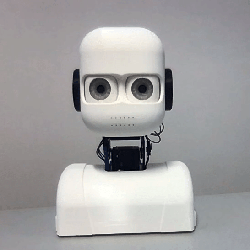

In [39]:
test_path = 'datasets/face_dataset_test_images/epi/epi5.jpg'
test_image = image.load_img(test_path, target_size=(img_height, img_width, 3))
test_image

In [40]:
test_image = image.img_to_array(test_image)  # from image to array
# shape from (250, 250, 3) to (1, 250, 250, 3)
test_image = np.expand_dims(test_image, axis=0)
result = face_classifier.predict(test_image)

for index in range(num_classes):
    print("{:6} with probabily of {:.2f}%".format(
        class_names[index], result[0][index] * 100))

1/1 [==============================] - 0s 27ms/step
epi    with probabily of 100.00%
human  with probabily of 0.00%
not_human with probabily of 0.00%


: 